In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


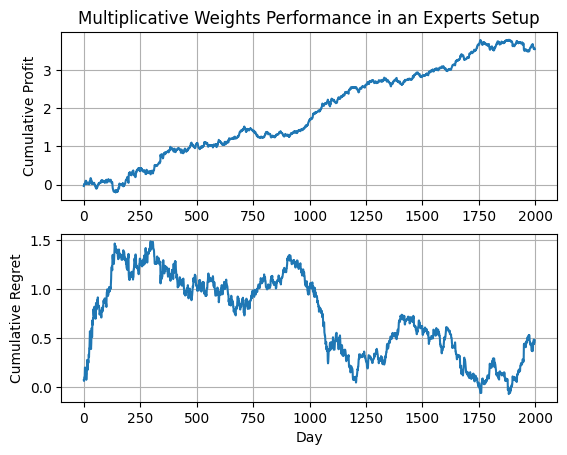

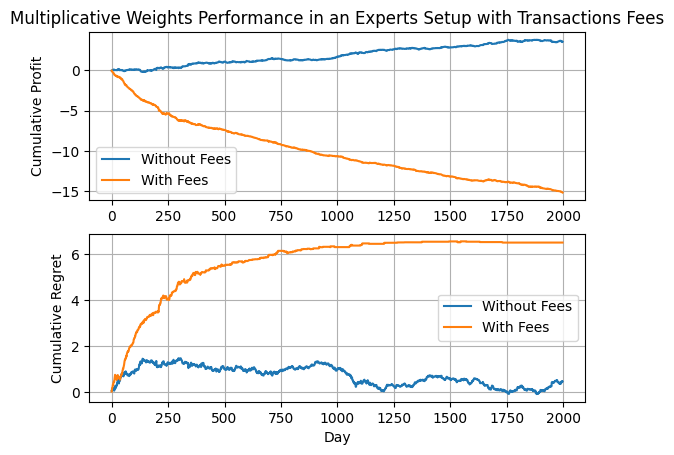

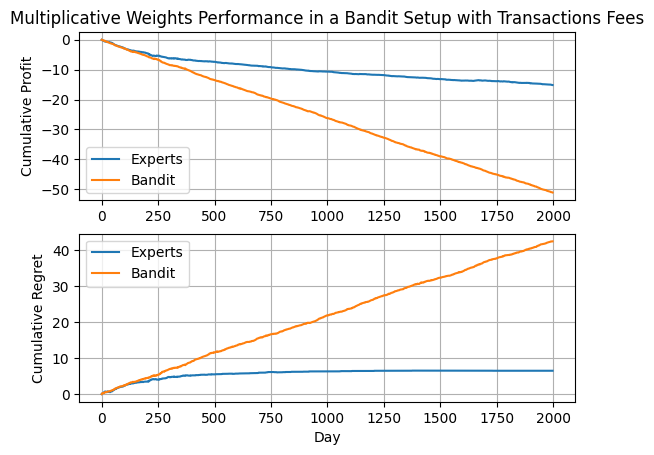

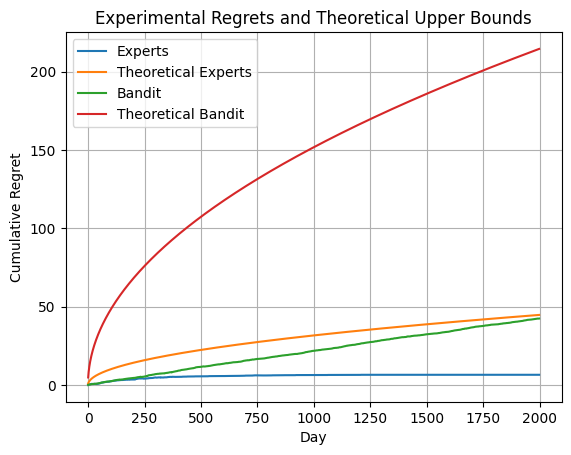

In [49]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Implement the Multiplicative Weights algorithm in a Bandit Setup
def bandit_multiplicative_weights(price_changes):
  total_days, num_stocks = price_changes.shape  # T = 1999 (horizon) and K = 10 (experts)
  weights = np.ones(num_stocks)  # Initialize the weight of each stock to 1
  eta = np.sqrt(np.log(num_stocks) / (total_days * num_stocks))  # Find the optimal learning rate eta
  epsilon = np.sqrt(num_stocks * np.log(num_stocks) / total_days)  # Find the optimal exploration parameter
  cumulative_profit = np.zeros(total_days)  # Array keeping track of the cumulative profit from the first day to the last one
  stock_losses = np.zeros((total_days, num_stocks))  # Array keeping track of the cumulative loss of each stock from the first day to the last one
  algo_loss = np.zeros(total_days)  # Array keeping track of the cumulative loss of the Multiplicative Weights algorithm
  optimal_loss = np.zeros(total_days)  # Array keeping track of the lowest cumulative loss of those presented by each stock up to the corresponding day
  # Cumulative regret is defined as the difference between the cumulative loss of the MW algorithm and the lowest cumulative loss of those presented by each stock up to the corresponding day
  cumulative_regret = np.zeros(total_days)  # Array keeping track of the cumulative regret

  for day in range(total_days):
    p = weights / np.sum(weights)  # Calculate the probabilities by normalizing the weights so that their sum is 1
    q = (1 - epsilon) * p + epsilon / num_stocks  # Add some exploration
    chosen_stock = np.random.choice(num_stocks, p=q)  # Randomly select one of the 10 stocks based on their probabilities
    profit = price_changes[day, chosen_stock]  # Get a profit based on the 1 euro investment and the price increase or decrease of the chosen stock for the given day
    if day > 0:
      cumulative_profit[day] = cumulative_profit[day-1] + profit
      for stock in range(num_stocks):
        stock_losses[day, stock] = stock_losses[day-1, stock] - price_changes[day, stock]
      algo_loss[day] = algo_loss[day-1] - profit
    else:
      cumulative_profit[day] = profit
      for stock in range(num_stocks):
        stock_losses[day, stock] = - price_changes[day, stock]
      algo_loss[day] = - profit
    optimal_loss[day] = np.min(stock_losses[day])
    cumulative_regret[day] = algo_loss[day] - optimal_loss[day]
    # Use the min-max scaling (normalization) method to rescale the range of the day's price changes to scale the range in [0, 1]
    # By doing this the Multiplicative Weights algorithm can be modified to maximize profits instead of minimizing losses
    # Effective loss is defined as (1 - scaled price change) and is used to change the weights of the algorithm
    # Essentially all price changes of the day are considered losses, with lower losses actually representing profits
    loss = 1 - (profit - np.min(price_changes[day, :])) / (np.max(price_changes[day, :]) - np.min(price_changes[day, :]))
    estimated_loss = loss / q[chosen_stock]
    weights[chosen_stock] *= (1 - eta) ** estimated_loss
  return cumulative_profit, cumulative_regret

# Implement the Multiplicative Weights algorithm in an Experts Setup
def experts_multiplicative_weights(price_changes):
  total_days, num_stocks = price_changes.shape  # T = 1999 (horizon) and K = 10 (experts)
  weights = np.ones(num_stocks)  # Initialize the weight of each stock to 1
  # In theory the optimal learning rate is defined as eta = np.sqrt(np.log(num_stocks) / total_days) and it must belong in the range (0, 0.5]
  # However, this value may need need to be increased a bit in case it is too low and makes the algorithm improve very slowly and therefore lose money
  eta = np.sqrt(np.log(num_stocks) / total_days)
  cumulative_profit = np.zeros(total_days)  # Array keeping track of the cumulative profit from the first day to the last one
  # Effective loss is defined as (1 - scaled price change) and is used to change the weights of the algorithm
  # Essentially all price changes of the day are considered losses, with lower losses actually representing profits
  effective_losses = np.zeros(num_stocks)
  stock_losses = np.zeros((total_days, num_stocks))  # Array keeping track of the cumulative loss of each stock from the first day to the last one
  algo_loss = np.zeros(total_days)  # Array keeping track of the cumulative loss of the Multiplicative Weights algorithm
  optimal_loss = np.zeros(total_days)  # Array keeping track of the lowest cumulative loss of those presented by each stock up to the corresponding day
  # Cumulative regret is defined as the difference between the cumulative loss of the MW algorithm and the lowest cumulative loss of those presented by each stock up to the corresponding day
  cumulative_regret = np.zeros(total_days)  # Array keeping track of the cumulative regret

  for day in range(total_days):
    probabilities = weights / np.sum(weights)  # Calculate the probabilities by normalizing the weights so that their sum is 1
    chosen_stock = np.random.choice(num_stocks, p=probabilities)  # Randomly select one of the 10 stocks based on their probabilities
    profit = price_changes[day, chosen_stock]  # Get a profit based on the 1 euro investment and the price increase or decrease of the chosen stock for the given day
    if day > 0:
      cumulative_profit[day] = cumulative_profit[day-1] + profit
      for stock in range(num_stocks):
        stock_losses[day, stock] = stock_losses[day-1, stock] - price_changes[day, stock]
      algo_loss[day] = algo_loss[day-1] - profit
    else:
      cumulative_profit[day] = profit
      for stock in range(num_stocks):
        stock_losses[day, stock] = - price_changes[day, stock]
      algo_loss[day] = - profit
    optimal_loss[day] = np.min(stock_losses[day])
    cumulative_regret[day] = algo_loss[day] - optimal_loss[day]
    # Use the min-max scaling (normalization) method to rescale the range of the day's price changes to scale the range in [0, 1]
    # By doing this the Multiplicative Weights algorithm can be modified to maximize profits instead of minimizing losses
    effective_losses = 1 - (price_changes[day, :] - np.min(price_changes[day, :])) / (np.max(price_changes[day, :]) - np.min(price_changes[day, :]))
    for i in range(num_stocks):
      weights[i] *= (1 - eta) ** effective_losses[i]
  return cumulative_profit, cumulative_regret

########## Task 1 ##########
# Read the day-to-day % price changes in 10 stocks for a duration of 1999 days from the corresponding file
df = pd.read_csv('stocks.csv', delimiter=',', header=None)
price_changes = df.to_numpy()  # Convert the DataFrame to a NumPy array
cumulative_profit_1, cumulative_regret_1 = experts_multiplicative_weights(price_changes)

########## Task 2 ##########
transactions_fees = np.arange(0.005, 0.005 * price_changes.shape[1] + 0.005, 0.005)  # Each stock has a fixed transaction cost
# Since the transaction cost for each stock is fixed and the investment is always 1 euro per day,
# subtract the corresponding transaction cost from each price change of each stock for all days
price_changes = price_changes - transactions_fees  # Subtract the vector transactions_fees from each row of the matrix price_changes
cumulative_profit_2, cumulative_regret_2 = experts_multiplicative_weights(price_changes)

########## Task 3 ##########
cumulative_profit_3, cumulative_regret_3 = bandit_multiplicative_weights(price_changes)

plt.figure()
plt.subplot(2, 1, 1)
plt.title("Multiplicative Weights Performance in an Experts Setup")
plt.ylabel("Cumulative Profit")
plt.grid(True)
plt.plot(cumulative_profit_1)
plt.subplot(2, 1, 2)
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.plot(cumulative_regret_1)

plt.figure()
plt.subplot(2, 1, 1)
plt.title("Multiplicative Weights Performance in an Experts Setup with Transactions Fees")
plt.ylabel("Cumulative Profit")
plt.grid(True)
plt.plot(cumulative_profit_1, label='Without Fees')
plt.plot(cumulative_profit_2, label='With Fees')
plt.legend()
plt.subplot(2, 1, 2)
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.plot(cumulative_regret_1, label='Without Fees')
plt.plot(cumulative_regret_2, label='With Fees')
plt.legend()

plt.figure()
plt.subplot(2, 1, 1)
plt.title("Multiplicative Weights Performance in a Bandit Setup with Transactions Fees")
plt.ylabel("Cumulative Profit")
plt.grid(True)
plt.plot(cumulative_profit_2, label='Experts')
plt.plot(cumulative_profit_3, label='Bandit')
plt.legend()
plt.subplot(2, 1, 2)
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.plot(cumulative_regret_2, label='Experts')
plt.plot(cumulative_regret_3, label='Bandit')
plt.legend()

plt.figure()
plt.title("Experimental Regrets and Theoretical Upper Bounds")
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.grid(True)
plt.plot(cumulative_regret_2, label='Experts')
plt.plot(np.sqrt(np.arange(1, price_changes.shape[0] + 1)), label='Theoretical Experts')
plt.plot(cumulative_regret_3, label='Bandit')
plt.plot(np.sqrt(np.arange(1, price_changes.shape[0] + 1) * price_changes.shape[1] * np.log(price_changes.shape[1])), label='Theoretical Bandit')
plt.legend()

plt.show()


# Analysis of Plots

In the second figure, we observe that the inclusion of transaction fees increases the cumulative regret and drastically reduces the cumulative profit, turning it negative over time. This goes to show that transaction fees can make an otherwise profitable strategy unviable.

In the final figure, we observe that the regret in the bandit setup grows faster compared to the experts setup. This is due to the algorithm having less
information to make its decisions (no access to the losses of all stocks). However, it still grows sublinearly, which is a desired property.

Although the profit in the last 2 scenarios is significantly reduced, the Multiplicative Weights algorithm seems to perform relatively good in both the experts and bandit setups, with the actual cumulative regrets being lower than their theoretical upper bounds.
